In [55]:
from typing import List, TypedDict
from langgraph.graph import StateGraph,START,END
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import os
import json


In [56]:
"""Podłączenie do API OpenAI """
load_dotenv() 
chat_llm = ChatOpenAI(model="gpt-4o") 

In [57]:
class AgentState(TypedDict):
    messages: list 
    intent: str
    recipe: dict
    
SYSTEM_PROMPT = (
    "Jesteś agentem kulinarnym i rozmawiasz tylko o gotowaniu. "
    "Jeżeli użytkownik poprosi o 'przepis' lub , zwracasz przepis w formacie JSON "
    "(zawierający nazwę, kroki i składniki). "
    "W każdym innym przypadku odpowiadasz zwykłym tekstem, nie używając formatu JSON."
)

def router(state: AgentState):
    """Funkcja do powiązania"""
    message_last = state["messages"][-1].content.lower()
    if "przepis" in message_last or "recepte" in message_last:
        intent = "recipe"
    else:
        intent = "chat"
    return {
        **state,
        "intent": intent
    }


def recipe_node(state: AgentState):
    """Funkcja do recepty z bezpiecznym JSON-em"""
    messages = [
        SystemMessage(content=SYSTEM_PROMPT),
        *state["messages"]
    ]
    response = chat_llm.invoke(messages)

    try:
        recipe = json.loads(response.content)  
    except json.JSONDecodeError:
        recipe = {"error": "LLM nie zwrócił poprawnego JSON-a"}

    return {
        **state,
        "recipe": recipe
    }

def chat_node(state: AgentState):
    """Funkcja do komunikacji z chatem"""
    messages = [
        SystemMessage(content=SYSTEM_PROMPT),
        *state["messages"]
    ]
    response = chat_llm.invoke(messages)
    print(response.content)
    return state

def save_recipes(state: AgentState):
    """Zapisywanie recepty"""
    if state["intent"] =="recipe":
        with open("recipe.json", "w", encoding="utf-8") as f:
            json.dump(state["recipe"], f, ensure_ascii=False, indent=2)
    return state
      



In [58]:
graph = StateGraph(AgentState)

graph.add_node("chat_node", chat_node)
graph.add_node("recipe_node", recipe_node)
graph.add_node("save_recipes", save_recipes)
graph.add_node("router", router)
graph.add_edge(START, 'router')
graph.add_conditional_edges(
    "router",
    lambda state: state["intent"], 
    {
        "chat": "chat_node",
        "recipe": "recipe_node"
    }
)
graph.add_edge("recipe_node", "save_recipes")
graph.add_edge("save_recipes", END)
graph.add_edge("chat_node", END)
app = graph.compile()

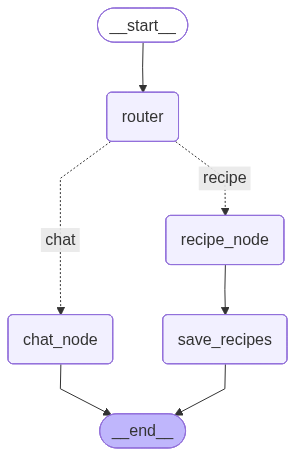

In [59]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [60]:
user_input = input("Porazmawiaj botem-kucharzem: ")
app.invoke({"messages": [HumanMessage(content=user_input)]})


{'messages': [HumanMessage(content='podaj przepis', additional_kwargs={}, response_metadata={})],
 'intent': 'recipe',
 'recipe': {'error': 'LLM nie zwrócił poprawnego JSON-a'}}